Nested sampling. Sticking with dynesty since jaxns uses too much memory when compiling, presumably due to `interp2d`.

In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from tqdm.auto import tqdm, trange

# Lots of small/large numbers involved in these calculations, so
# need to use 64-bit mode
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import random

from binary_jax import *
from analysis_jax import *
from noise import *

In [2]:
import dynesty
from dynesty import plotting as dyplot


m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)

#### Vacuum system
Not working...

In [3]:
r_M_chirp_MSUN_v = 1e-4
d_tT_c_v = 120

labels_v = (
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\tilde{t}_c$ [s]"
)

def ptform_v(u):
    return jnp.array([
        dd_s.M_chirp / MSUN * (1 + r_M_chirp_MSUN_v * (2 * u[0] - 1)),
        d_tT_c_v * (2 * u[1] - 1)
    ])

In [4]:
# @jax.jit
def logL_v(x):
    M_chirp_MSUN, tT_c = x
    vb_h = VacuumBinary(
        M_chirp_MSUN * MSUN,
        dd_s.Phi_c,  # fixed
        tT_c,
        dd_s.dL_iota,  # value doesn't matter
        dd_s.f_c
    )
    return loglikelihood(vb_h, dd_s, f_l, dd_s.f_c, 3000000, 3000)

In [5]:
logL_v(ptform_v(jnp.array([0.5, 0.5])))  # 3,000,000

DeviceArray(1.00182842e-07, dtype=float64)

Other numbers of points

In [47]:
logL_v(ptform_v(jnp.array([0.5, 0.5])))  # 3,000,000

DeviceArray(1.00182842e-07, dtype=float64)

In [45]:
logL_v(ptform_v(jnp.array([0.5, 0.5])))  # 1,000,000

DeviceArray(1.00187704e-07, dtype=float64)

In [7]:
logL_v(ptform_v(jnp.array([0.5, 0.5])))  # 500,000

DeviceArray(1.00263291e-07, dtype=float64)

In [43]:
logL_v(ptform_v(jnp.array([0.5, 0.5])))  # 300,000

DeviceArray(1.00842313e-07, dtype=float64)

In [41]:
logL_v(ptform_v(jnp.array([0.5, 0.5])))  # 100,000

Buffer(3.11774471e-07, dtype=float64)

In [37]:
logL_v(ptform_v(jnp.array([0.5, 0.5])))  # 30,000

DeviceArray(0.00760774, dtype=float64)

In [35]:
logL_v(ptform_v(jnp.array([0.5, 0.5])))  # 10,000

DeviceArray(0.05396034, dtype=float64)

In [33]:
logL_v(ptform_v(jnp.array([0.5, 0.5])))  # 3,000

DeviceArray(0.13300401, dtype=float64)

Check the likelihood directly

In [15]:
M_chirp_MSUNs = jnp.linspace(
#     dd_s.M_chirp / MSUN * (1 - 1 * r_M_chirp_MSUN_v),
#     dd_s.M_chirp / MSUN * (1 + 15 * r_M_chirp_MSUN_v),
    15.863, 15.875,
    40
)
tT_cs = jnp.linspace(
#     -1000 * d_tT_c_v, 1500 * d_tT_c_v,
    -100000, 0,
    35
)
M_chirp_MSUN_mg, tT_c_mg = jnp.meshgrid(M_chirp_MSUNs, tT_cs)

logLs = np.zeros_like(M_chirp_MSUN_mg)
for j in range(len(M_chirp_MSUNs)):
    for i in range(len(tT_cs)):
        logLs[i, j] = logL_v(jnp.array((M_chirp_MSUN_mg[i, j], tT_c_mg[i, j])))
# jax.vmap(logL_v)(
#     jnp.stack((M_chirp_MSUN_mg, tT_c_mg), axis=-1).reshape(-1, 2)
# ).reshape(M_chirp_MSUN_mg.shape)

Text(0, 0.5, '$\\tilde{t}_c$ [s]')

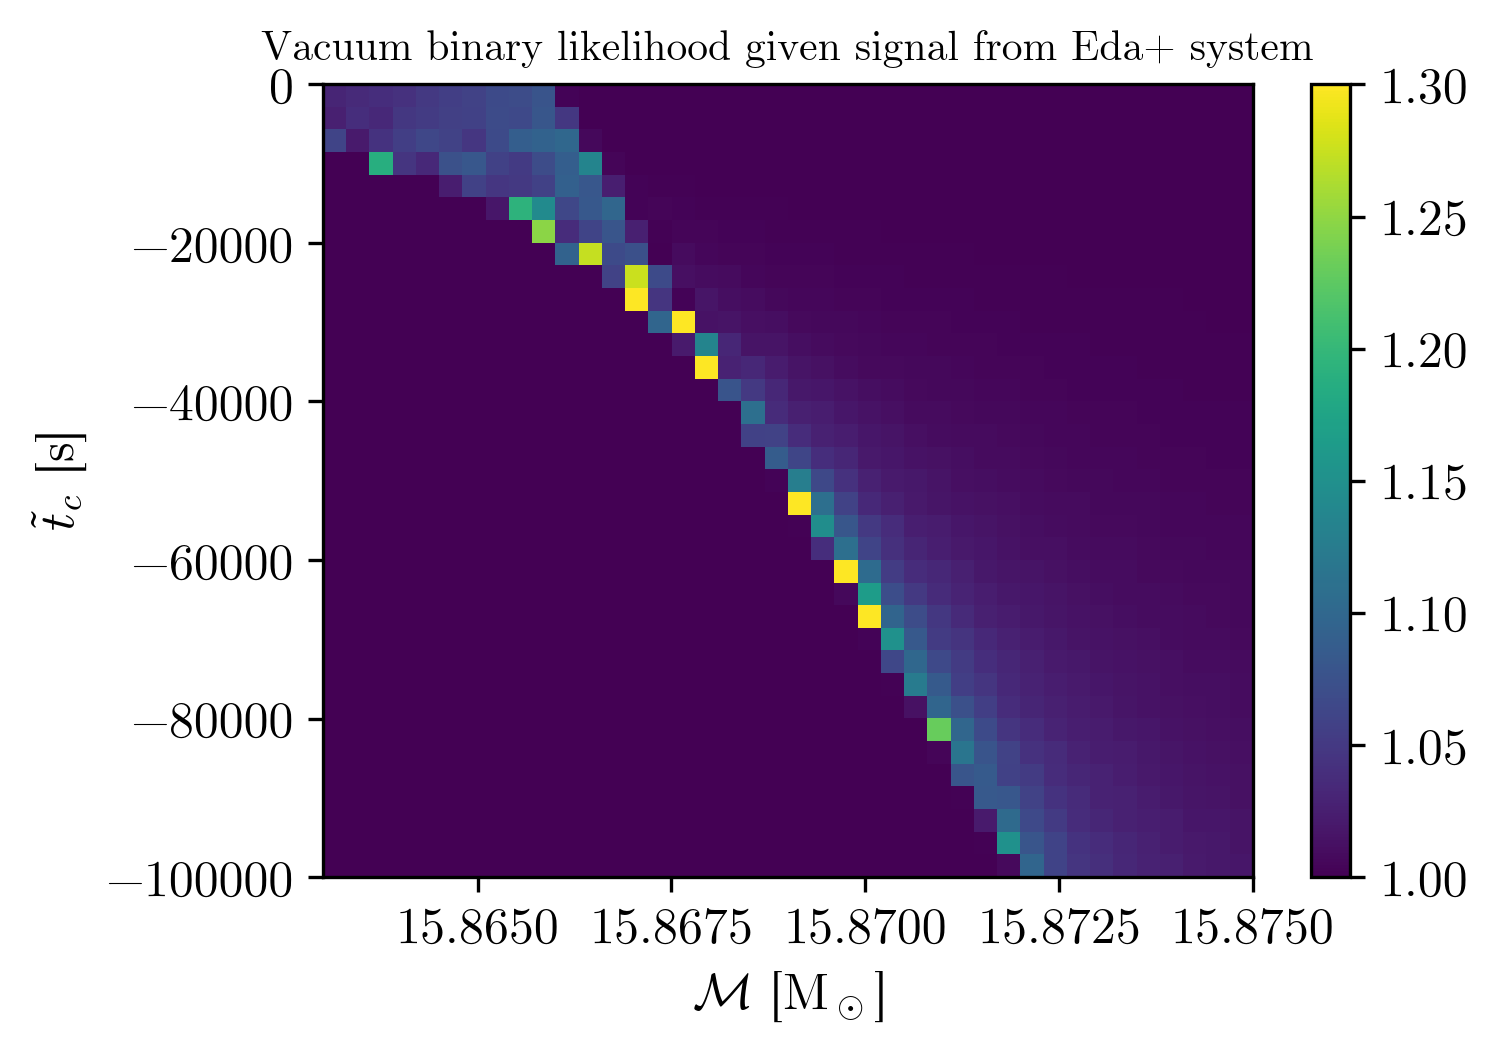

In [18]:
plt.imshow(
    jnp.exp(logLs),
    extent=(M_chirp_MSUNs[0], M_chirp_MSUNs[-1], tT_cs[0], tT_cs[-1]),
    origin="lower", aspect="auto", vmin=1, vmax=1.3
)
plt.colorbar()
plt.title("Vacuum binary likelihood given signal from Eda+ system", fontsize=10)
plt.xlabel(r"$\mathcal{M}$ [M$_\odot$]")
plt.ylabel(r"$\tilde{t}_c$ [s]")

In [ ]:
for i in list(range(0, 20, 4)):
    plt.plot(M_chirp_MSUNs, jnp.exp(logLs)[i, :], label=f"{tT_cs[i]}")

plt.legend()

Run nested sampling

In [224]:
sampler_v = dynesty.NestedSampler(
    logL_v, ptform_v, len(labels_v), nlive=300, bound="multi"
)
sampler_v.run_nested()
results_v = sampler_v.results

547it [00:05, 99.57it/s, +300 | bound: 0 | nc: 1 | ncall: 2086 | eff(%): 40.604 | loglstar:   -inf <  0.705 <    inf | logz:  0.124 +/-    nan | dlogz:  0.001 >  0.309]


In [226]:
results_v.summary()

Summary
nlive: 300
niter: 547
ncall: 2086
eff(%): 40.604
logz:  0.124 +/-  0.000


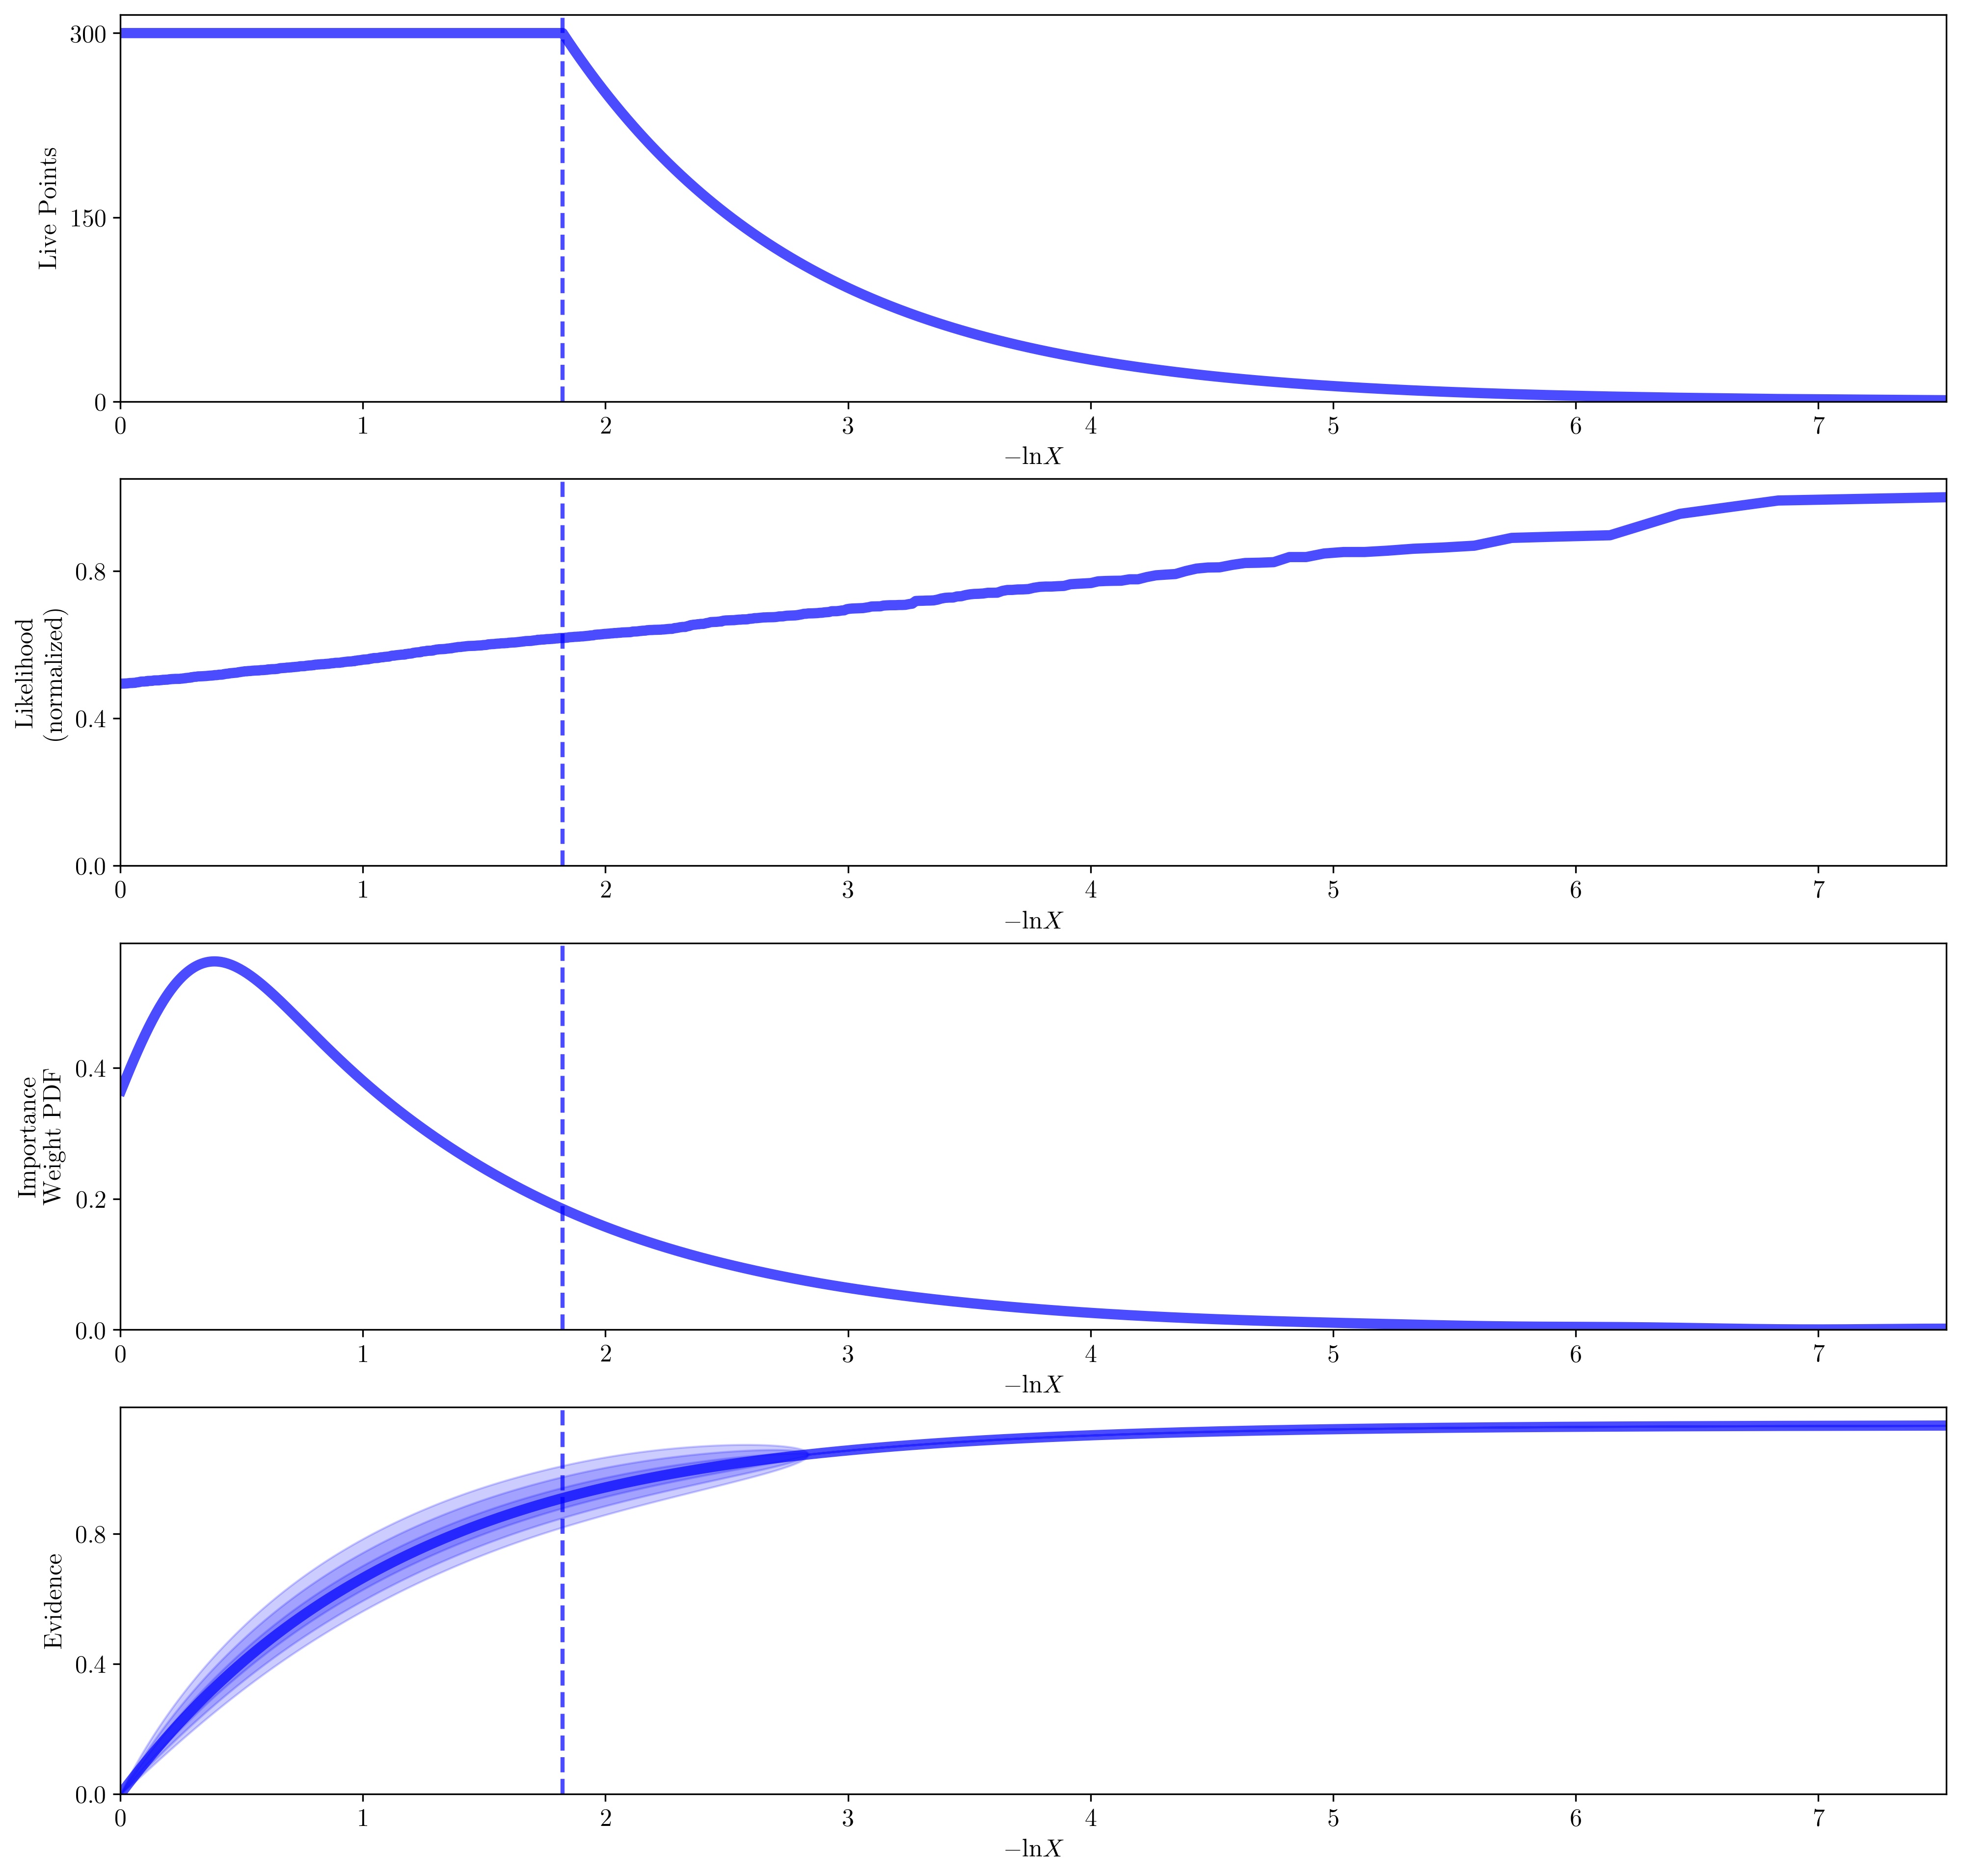

In [227]:
rfig, raxes = dyplot.runplot(results_v)

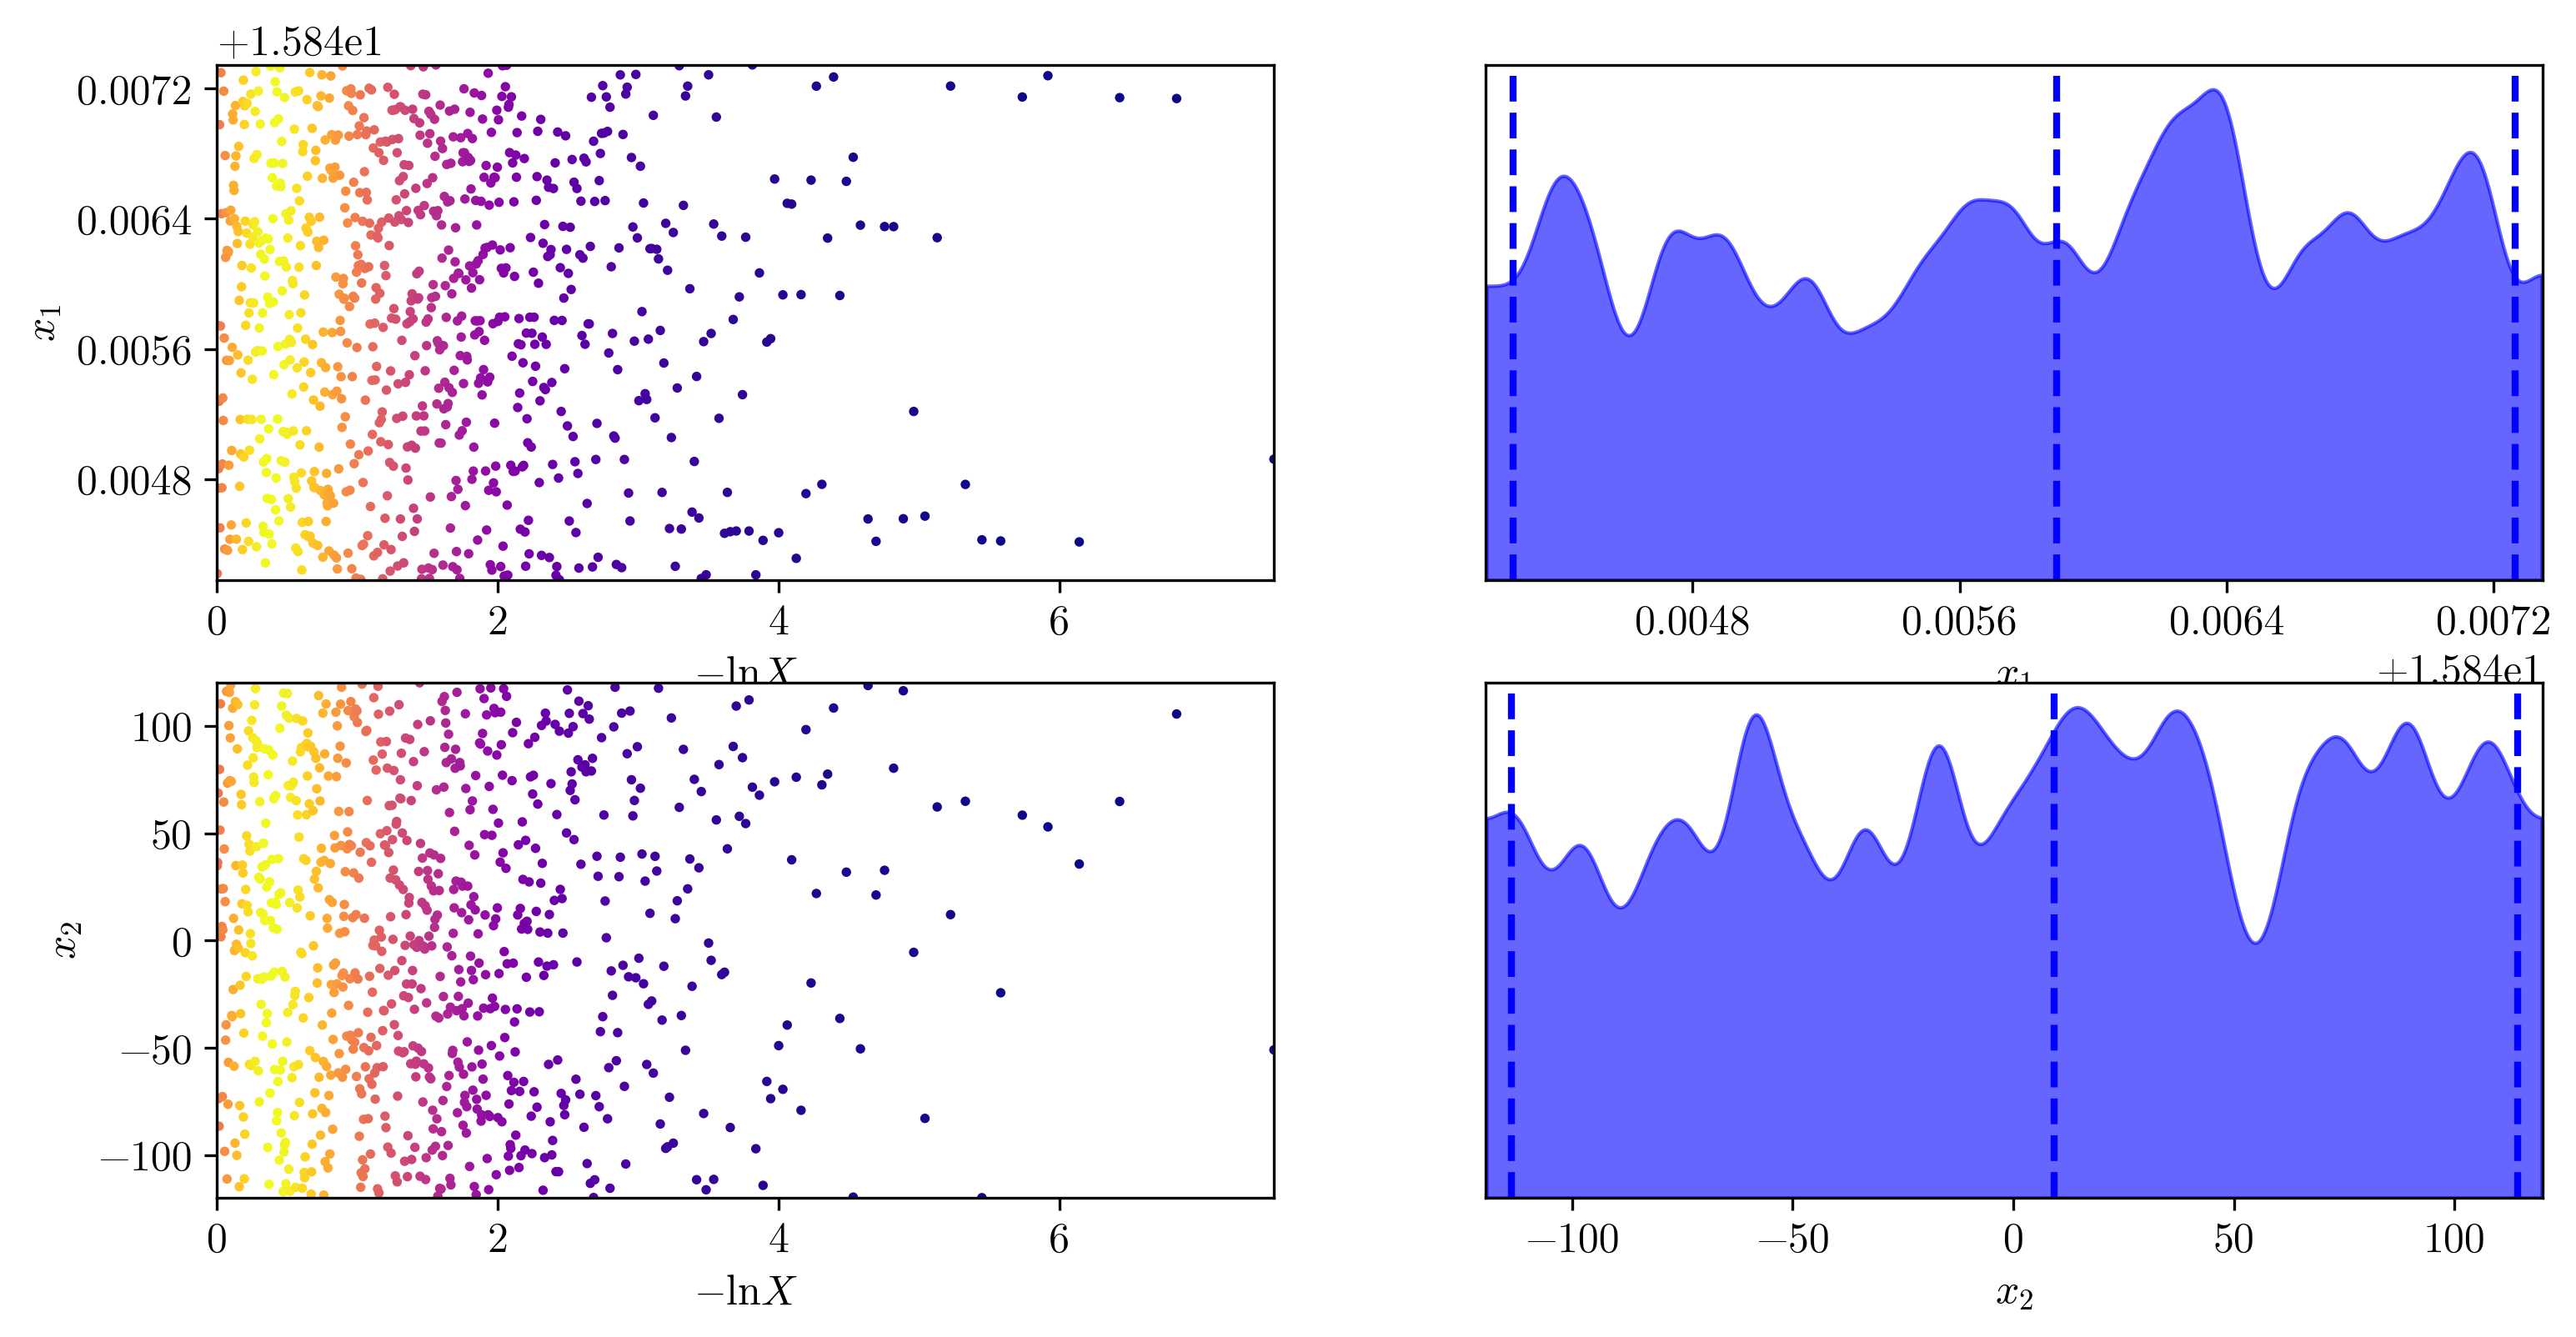

In [228]:
tfig, taxes = dyplot.traceplot(results_v)

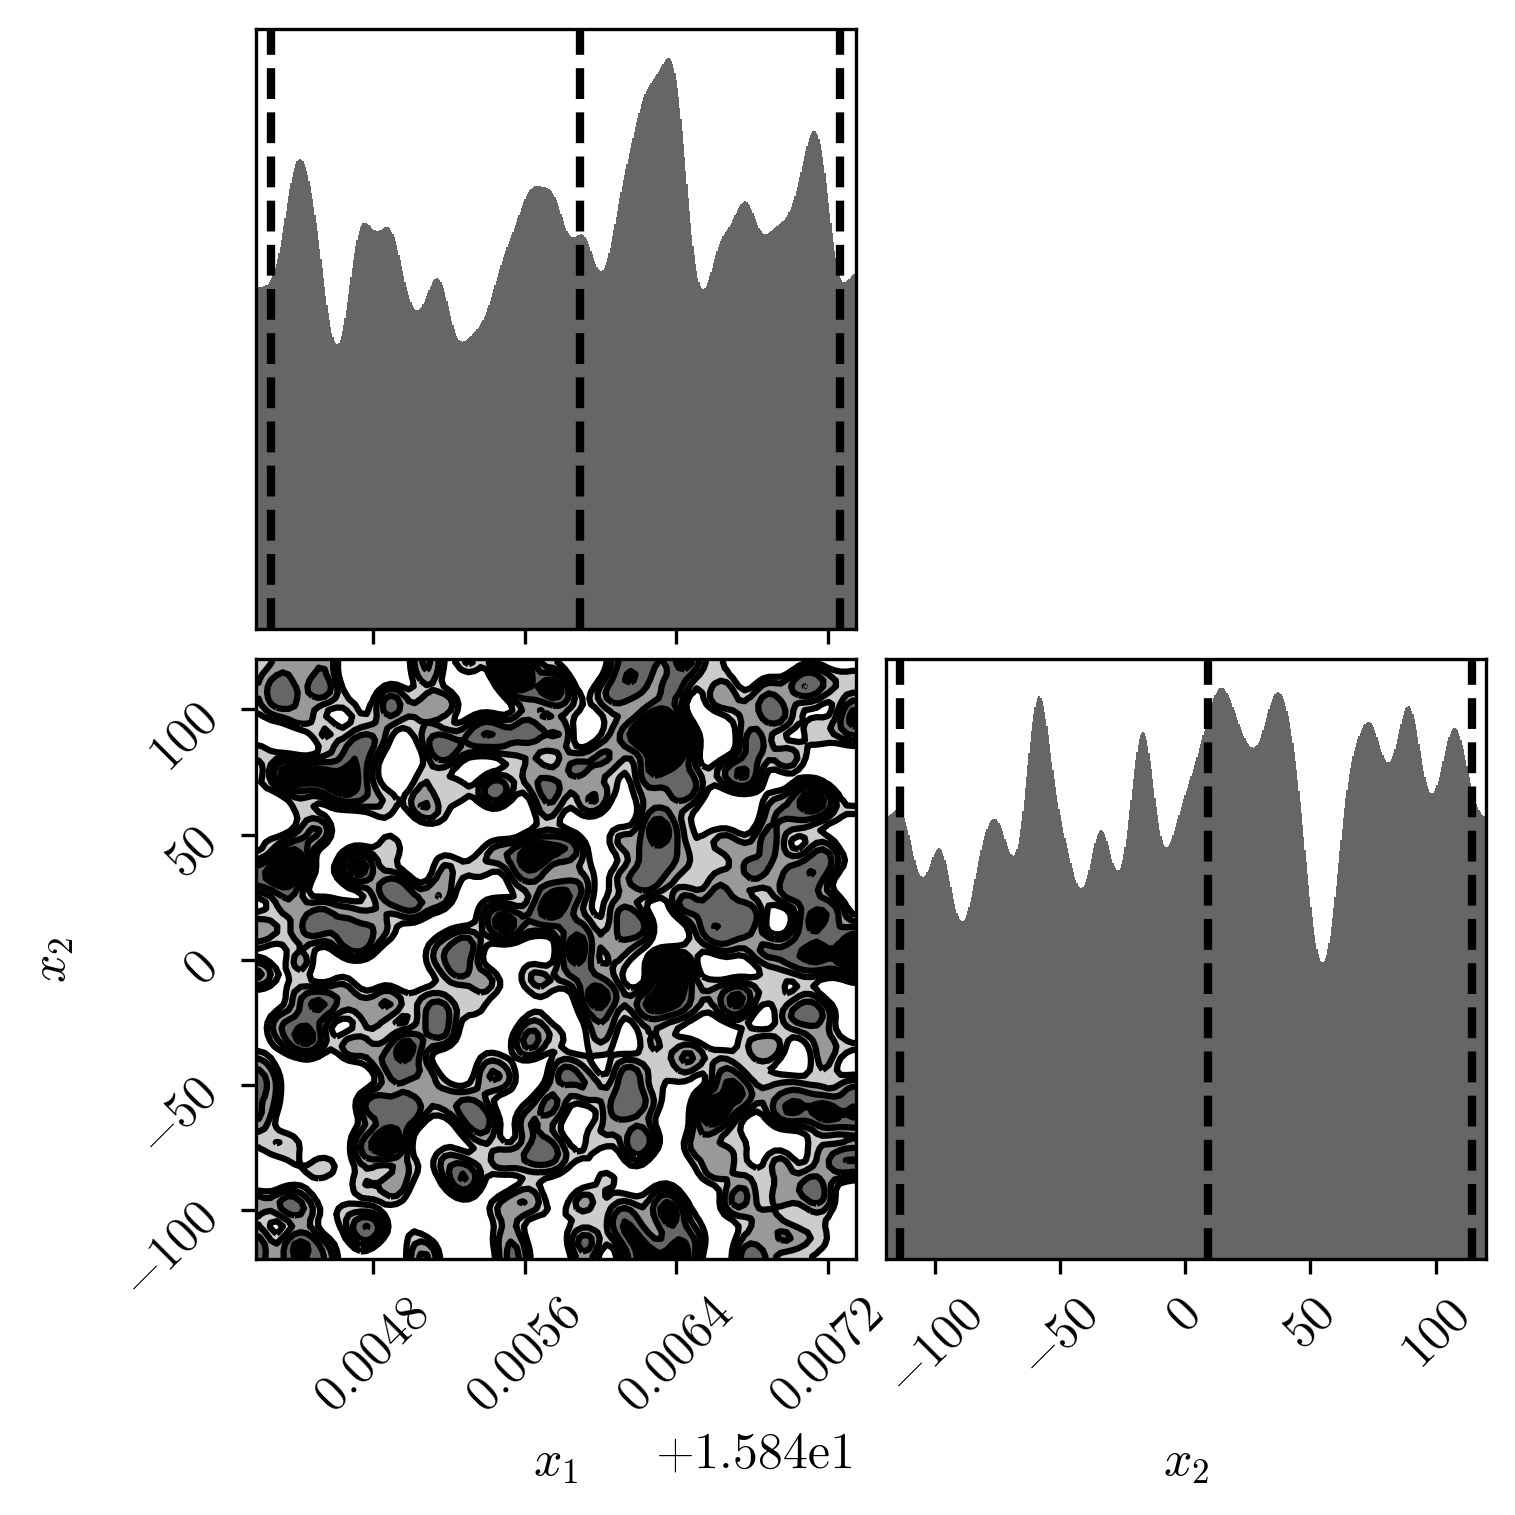

In [229]:
cfig, caxes = dyplot.cornerplot(results_v)

#### Dynamic dress
Working!

In [193]:
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)


# @jax.jit
def logL_4d(x):
    gamma_s, c_f, M_chirp_MSUN, tT_c = x
    dd_h = DynamicDress(
        gamma_s,
        c_f,
        M_chirp_MSUN * MSUN,
        dd_s.q,  # fixed
        dd_s.Phi_c,  # fixed
        tT_c,
        dd_s.dL_iota,  # value doesn't matter
        get_f_isco(get_m_1(M_chirp_MSUN * MSUN, dd_s.q))
    )
    f_h = jnp.maximum(dd_s.f_c, dd_h.f_c)
    return loglikelihood(dd_h, dd_s, f_l, f_h, 3000, 3000)

In [195]:
print(logL_4d(jnp.array([dd_s.gamma_s, dd_s.c_f, dd_s.M_chirp / MSUN, dd_s.tT_c])))
print(logL_4d(jnp.array([dd_s.gamma_s, dd_s.c_f, dd_s.M_chirp / MSUN, dd_s.tT_c])))

42.26262029583366
42.26262029583366


In [196]:
r_gamma_s = 1e-1
r_c_f = 2e-1
r_M_chirp_MSUN = 1e-4
d_tT_c = 120

labels = (
    r"$\gamma_s$",
    r"$c_f$ [?]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\tilde{t}_c$ [s]"
)

def ptform(u):
    return jnp.array([
        dd_s.gamma_s * (1 + r_gamma_s * (2 * u[0] - 1)),
        dd_s.c_f * (1 + r_c_f * (2 * u[1] - 1)),
        dd_s.M_chirp / MSUN * (1 + r_M_chirp_MSUN * (2 * u[2] - 1)),
        d_tT_c * (2 * u[3] - 1)
    ])

Run sampler

In [199]:
sampler = dynesty.NestedSampler(
    logL_4d, ptform, len(labels), nlive=2000, bound="multi"
)
sampler.run_nested()
results = sampler.results

36738it [57:50, 10.58it/s, +2000 | bound: 149 | nc: 1 | ncall: 526107 | eff(%):  7.363 | loglstar:   -inf < 42.098 <    inf | logz: 22.589 +/-  0.195 | dlogz:  0.002 >  2.009]


In [200]:
results.summary()

Summary
nlive: 2000
niter: 36738
ncall: 526107
eff(%):  7.363
logz: 22.589 +/-  0.195


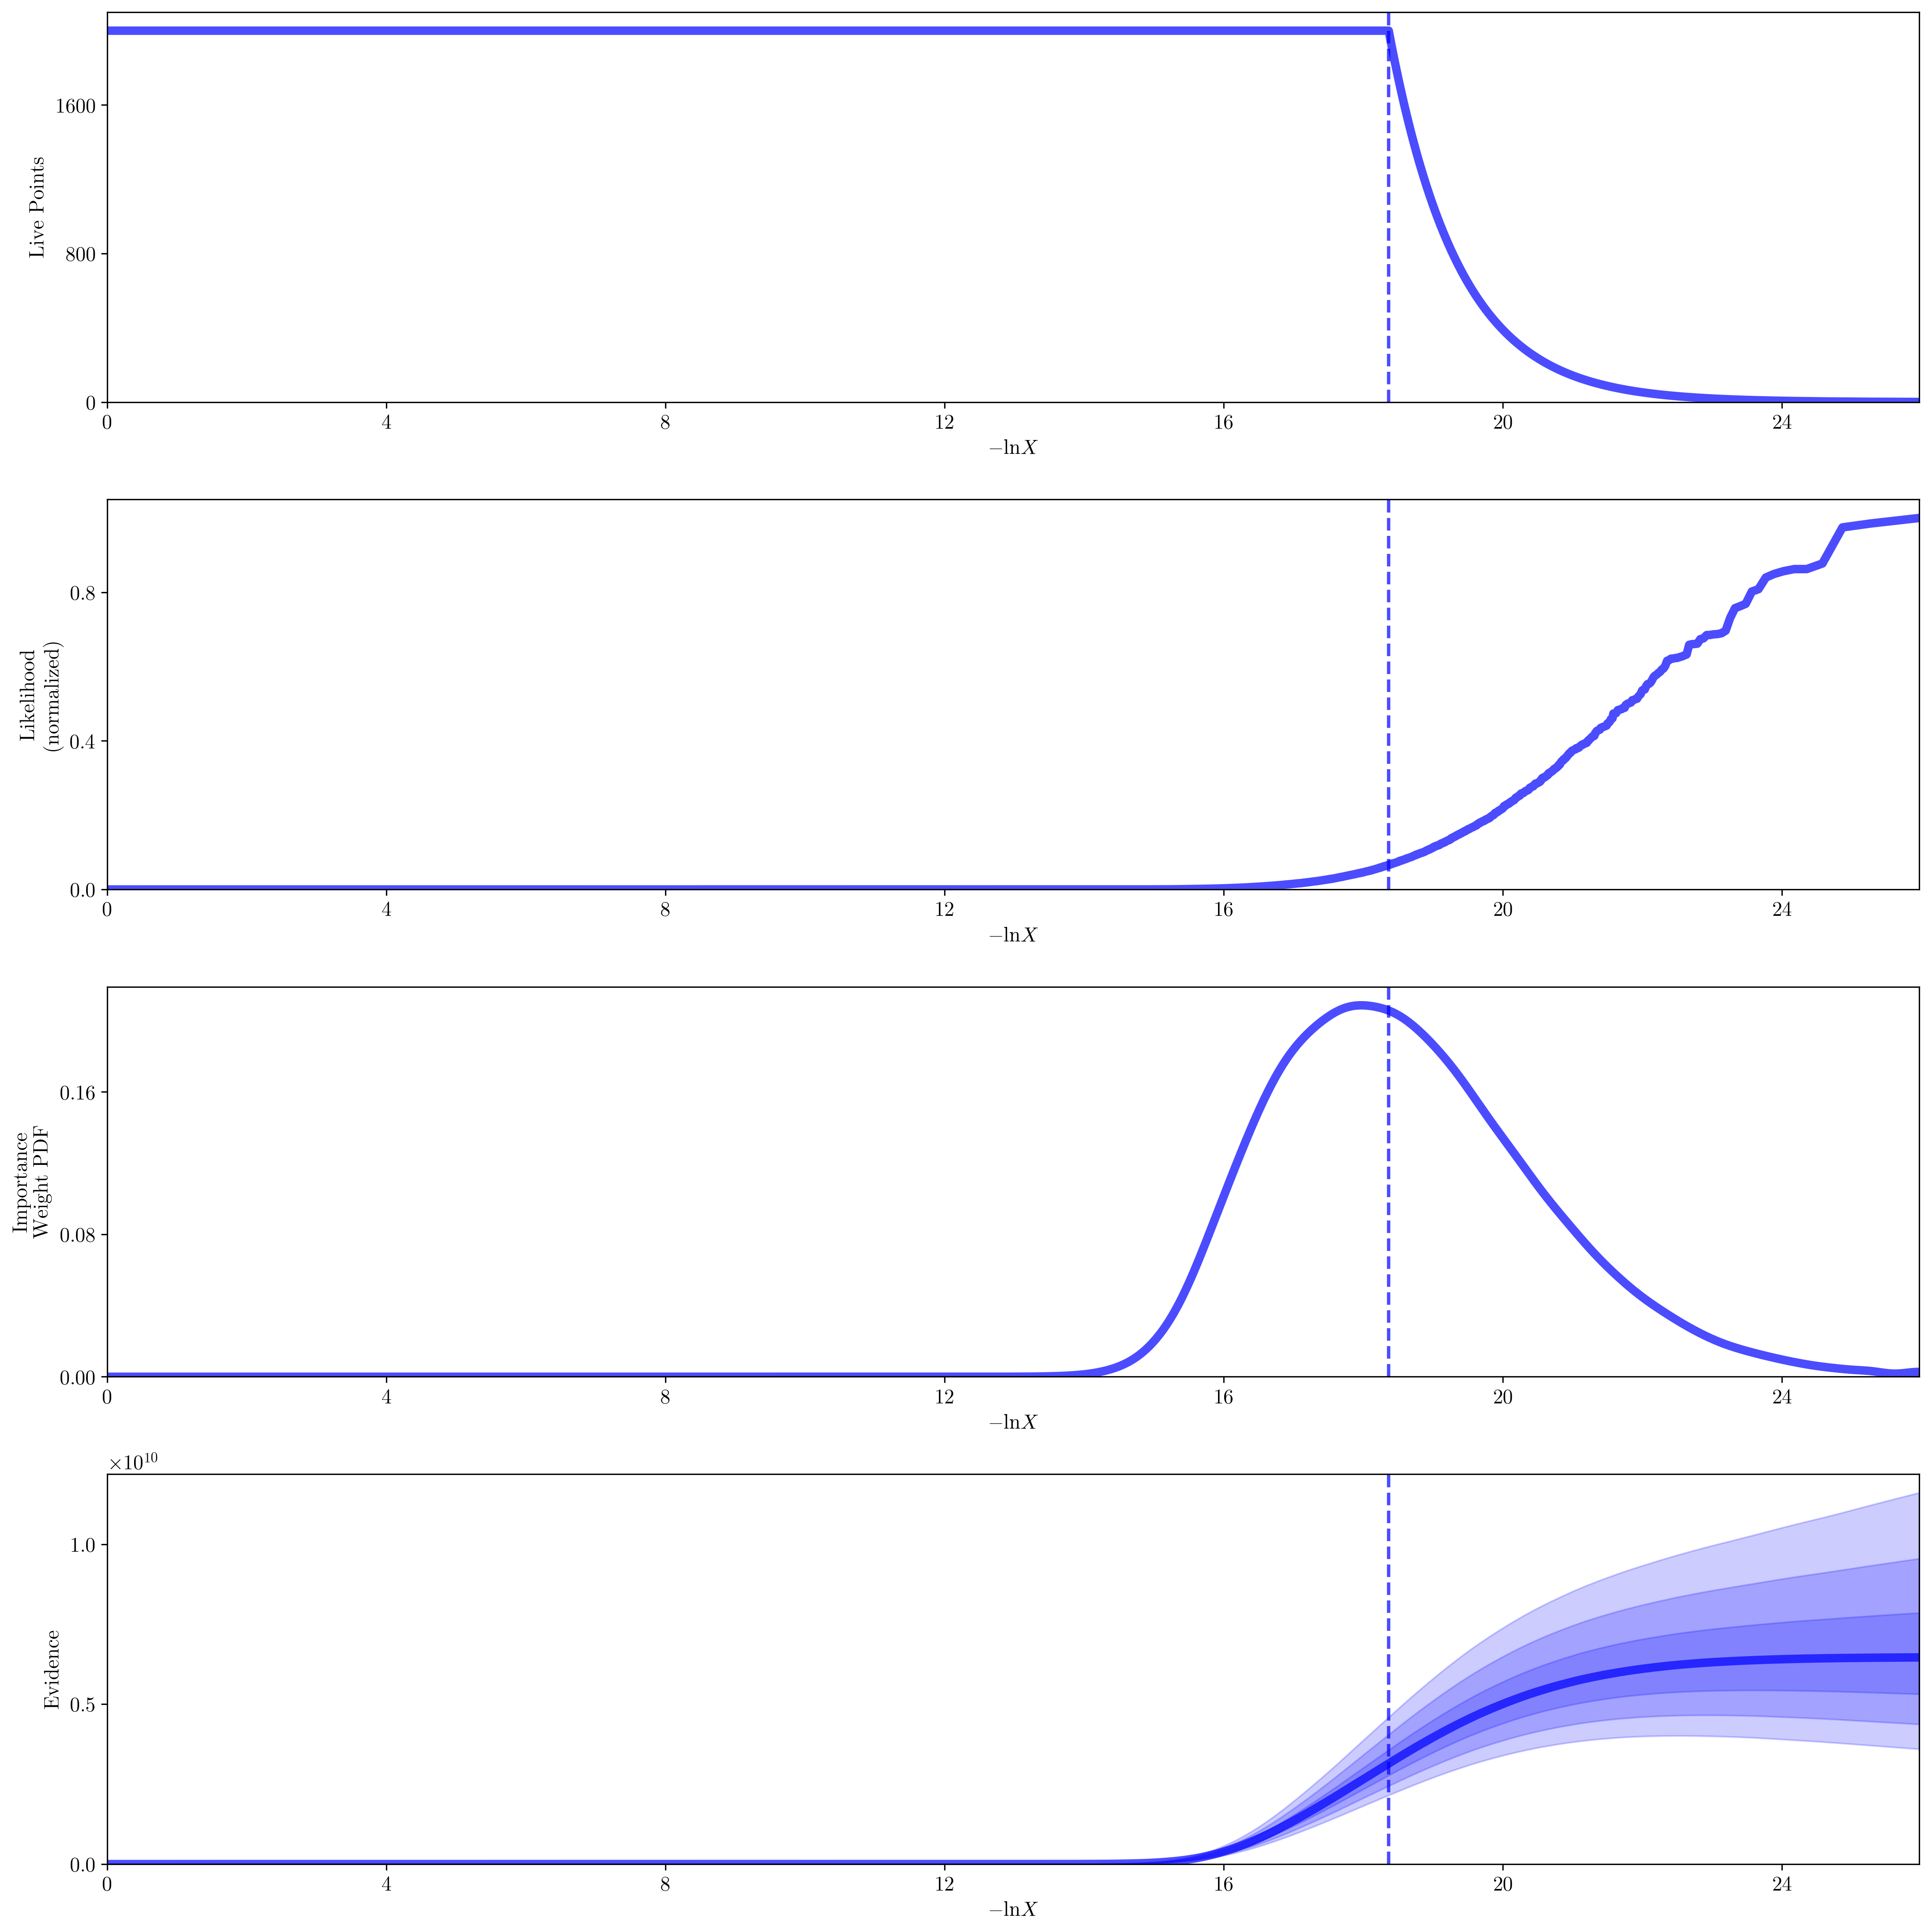

In [201]:
rfig, raxes = dyplot.runplot(results)
rfig.tight_layout()

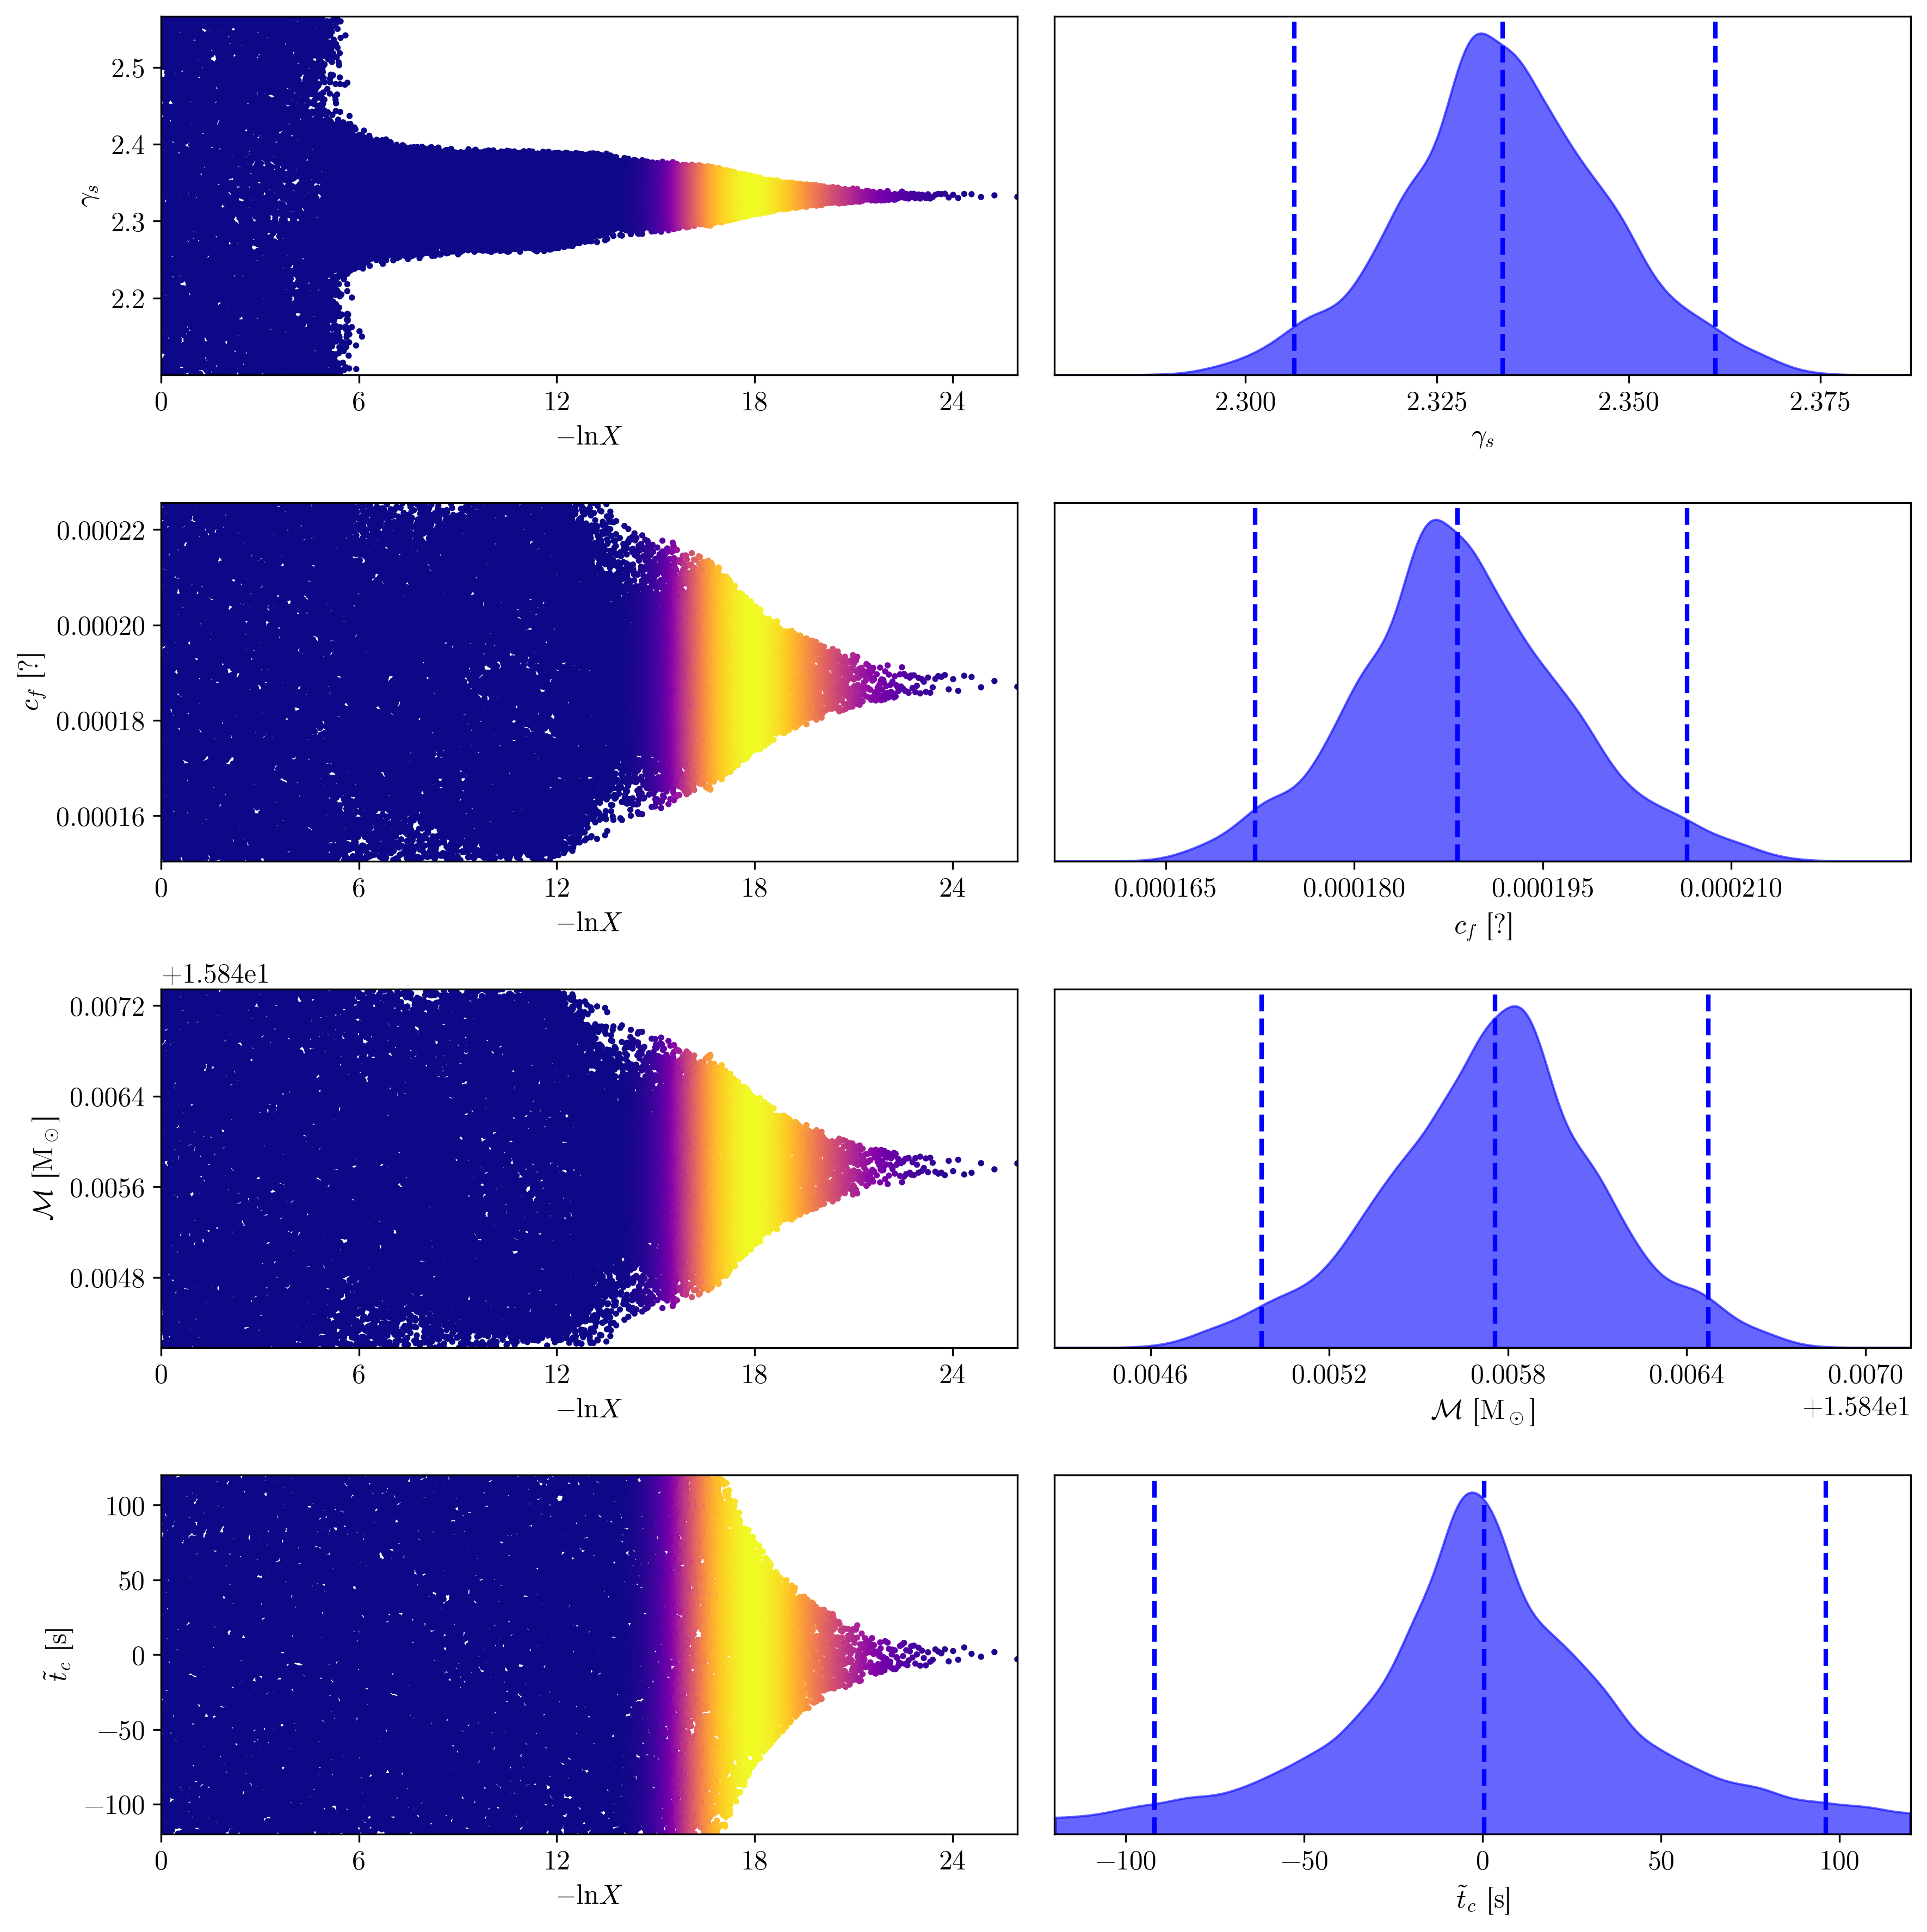

In [202]:
tfig, taxes = dyplot.traceplot(results, labels=labels)
tfig.tight_layout()

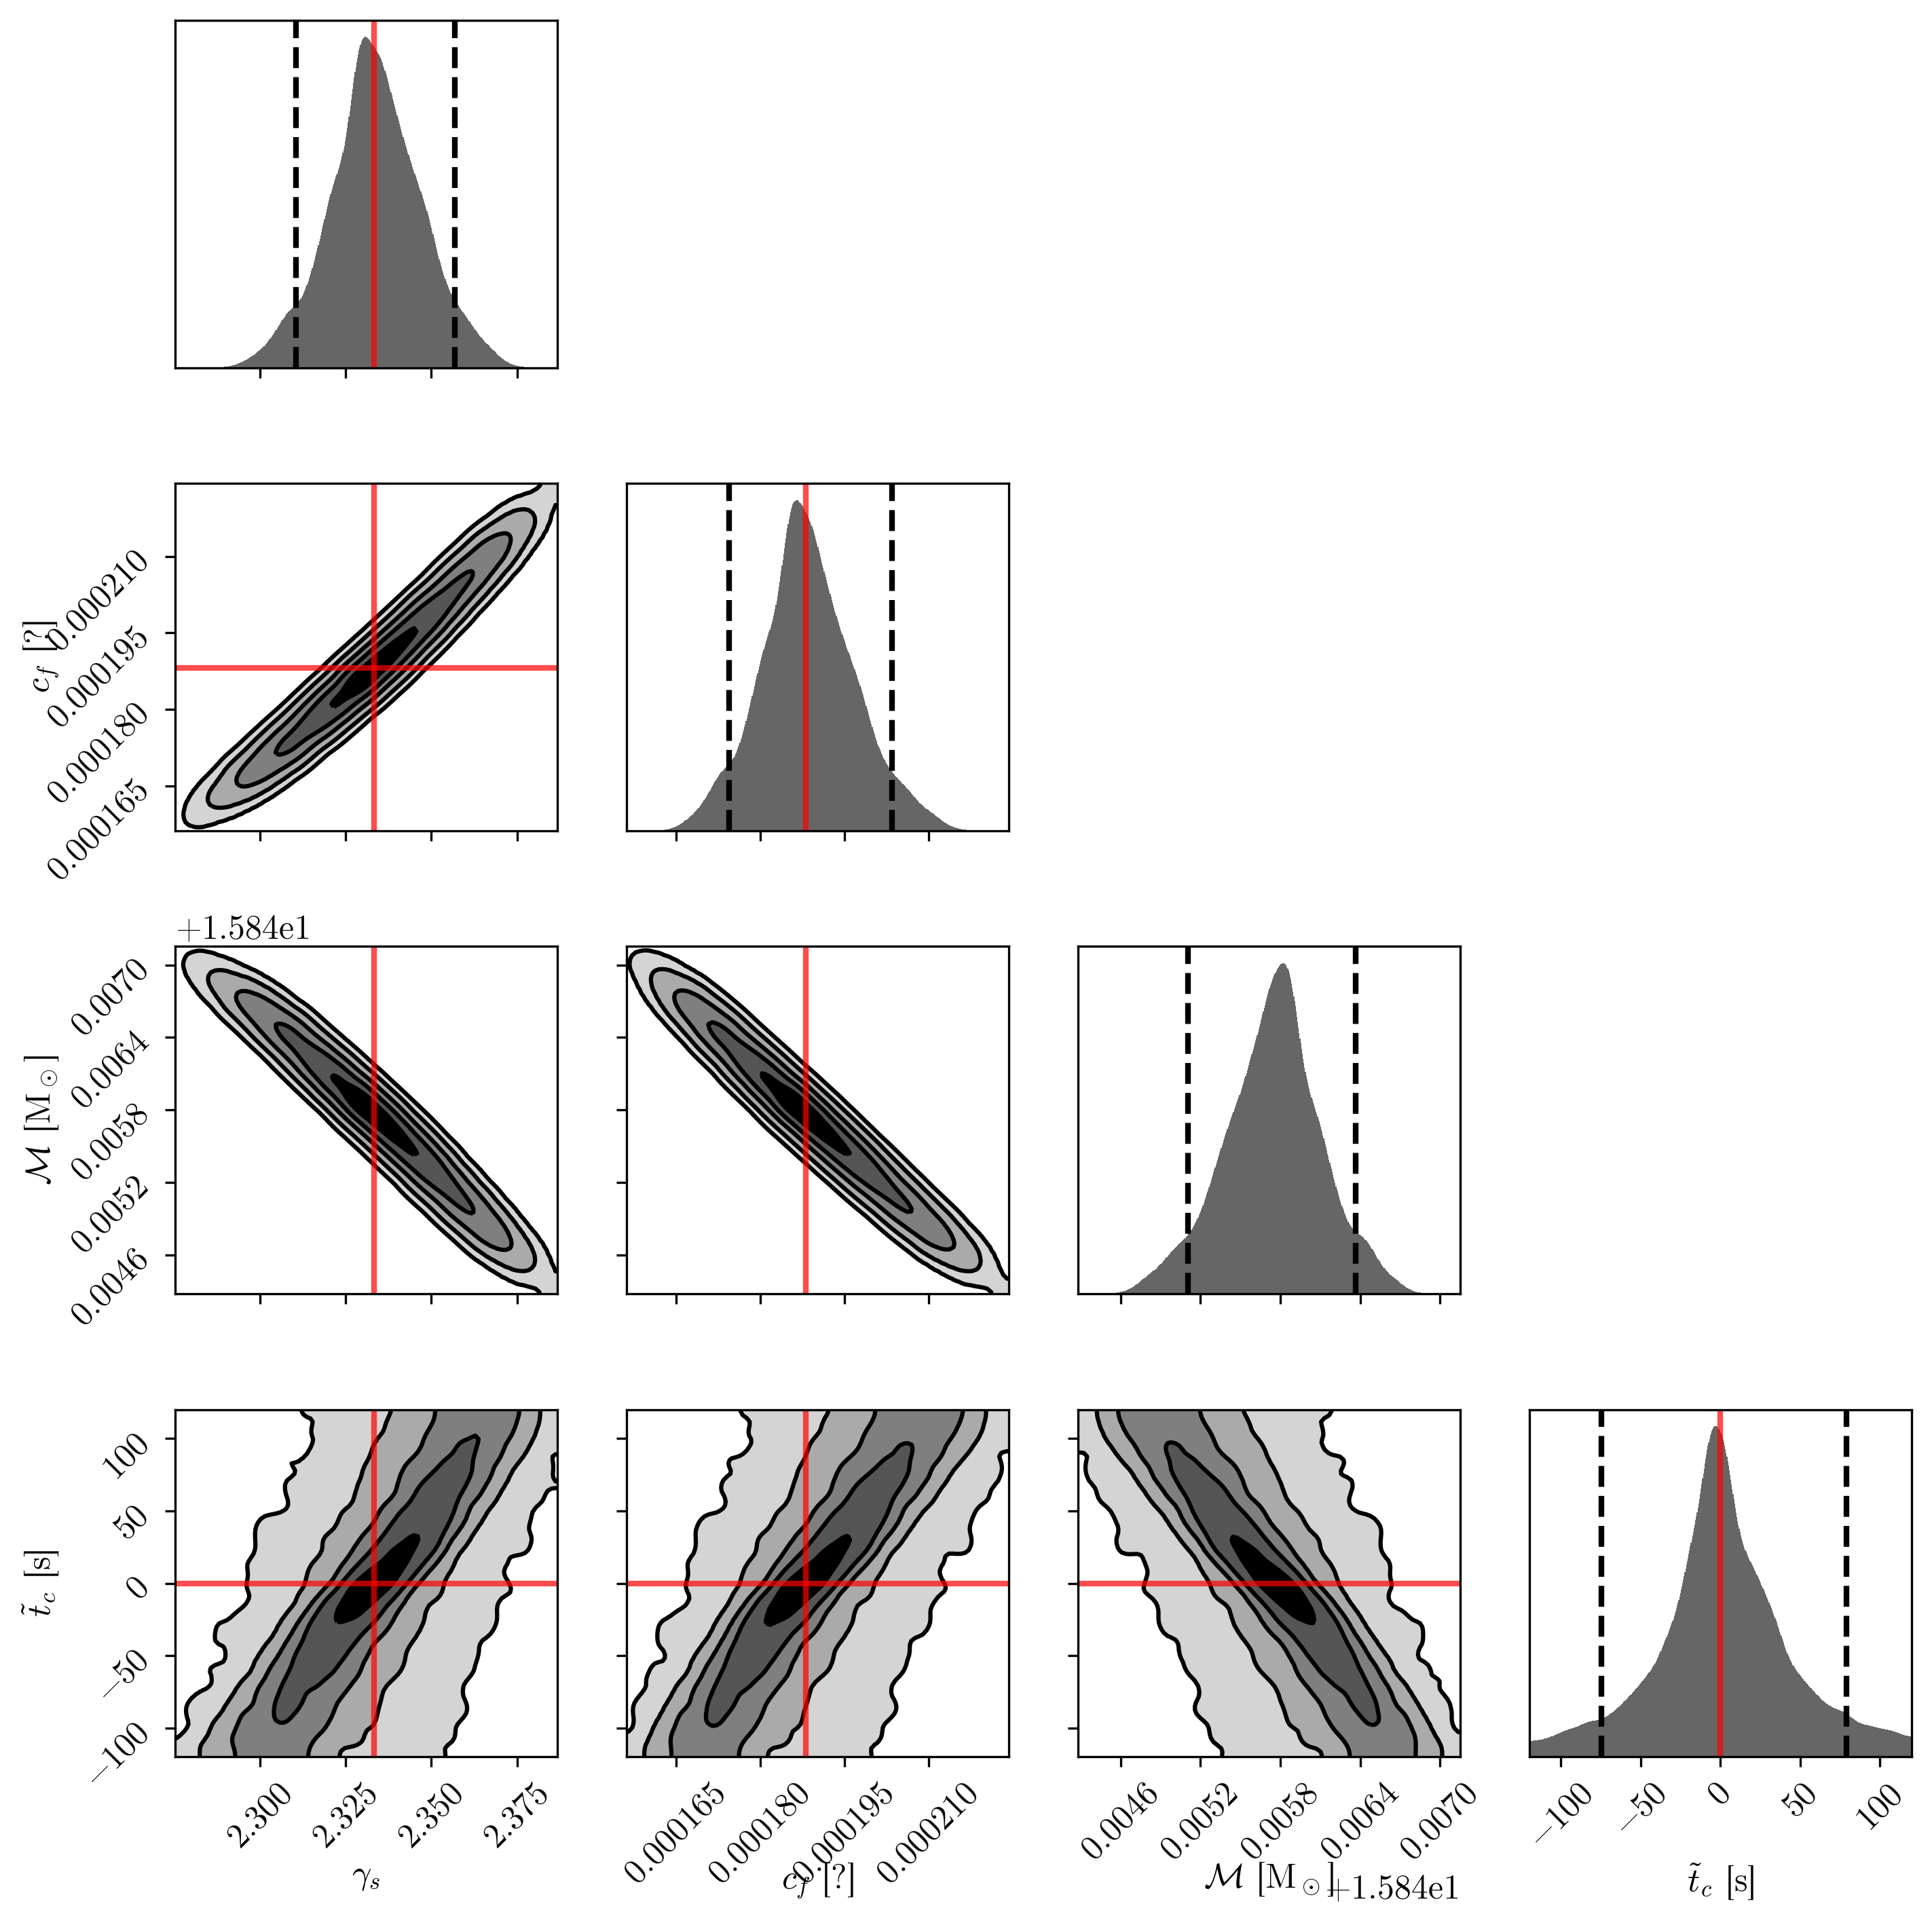

In [215]:
cfig, caxes = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles=[1 - 0.95, 0.95],
    quantiles_2d=[1 - np.exp(-x ** 2 / 2) for x in [1, 2, 3, 4, 5]],
    smooth=0.02,
#     cmap="viridis",
    truths=(dd_s.gamma_s, dd_s.c_f, dd_s.M_chirp, dd_s.tT_c),
#     kde=False
)
cfig.tight_layout()

#### Dynamic dress, fundamental parameters
Not working

In [2]:
import dynesty
from dynesty import plotting as dyplot

In [167]:
m_1_ref = jnp.array(1e3 * MSUN)
m_2_ref = jnp.array(1 * MSUN)
rho_s_ref = jnp.array(226 * MSUN / PC ** 3)
gamma_s_ref = jnp.array(7 / 3)
dL_ref = 1e8 * PC
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1_ref)
dd_s = make_dynamic_dress(m_1_ref, m_2_ref, rho_s_ref, gamma_s_ref, dL=dL_ref)


# @jax.jit
def logL(x):
    (
        m_1_MSUN,
        rho_s_MSUN_PC3,
        t_c
    ) = x
    
    m_1 = m_1_MSUN * MSUN
    m_2 = m_2_ref
    rho_s = rho_s_MSUN_PC3 * MSUN / PC**3
    gamma_s = gamma_s_ref
    
    c_f = get_c_f(m_1, m_2, rho_s, gamma_s)
    M_chirp = get_M_chirp(m_1, m_2)
    dL_iota = get_dL_iota(dL_ref, 0.)
    f_c = get_f_isco(m_1)
    dd_h = DynamicDress(
        gamma_s, c_f, M_chirp, m_2 / m_1, 0., t_c, dL_iota, f_c
    )
    
    f_h = jnp.maximum(dd_s.f_c, dd_h.f_c)
    return loglikelihood(dd_h, dd_s, f_l, f_h, 3000, 3000)

In [168]:
print(logL(jnp.array([
    m_1_ref / MSUN,
    rho_s_ref / (MSUN / PC**3),
    0.
])))
print(logL(jnp.array([
    m_1_ref / MSUN,
    rho_s_ref / (MSUN / PC**3),
    0.
])))

42.26262029583366
42.26262029583366


In [189]:
r_m_1_MSUN = 1.5e-5
d_rho_s_MSUN_PC3 = 2e-2
# r_gamma_s = 1e-1
d_t_c = 50

labels = (
    r"$m_1$ [M$_\odot$]",
    r"$\rho_s$ [M$_\odot$ pc$^3$]",
    r"$\tilde{t}_c$ [s]"
)

def ptform(u):
    x = jnp.array([
        m_1_ref / MSUN * (1 + r_m_1_MSUN * (2 * u[0] - 1)),
        rho_s_ref / (MSUN / PC**3) * (1 + d_rho_s_MSUN_PC3 * (2 * u[1] - 1)),
        d_t_c * (2 * u[2] - 1)
    ])
    return x

In [190]:
n = 1000
xs = np.zeros((n, len(labels)))
logLs = np.zeros(n)
for i in range(n):
    xs[i] = ptform(np.random.rand(xs.shape[1]))
    logLs[i] = logL(xs[i])

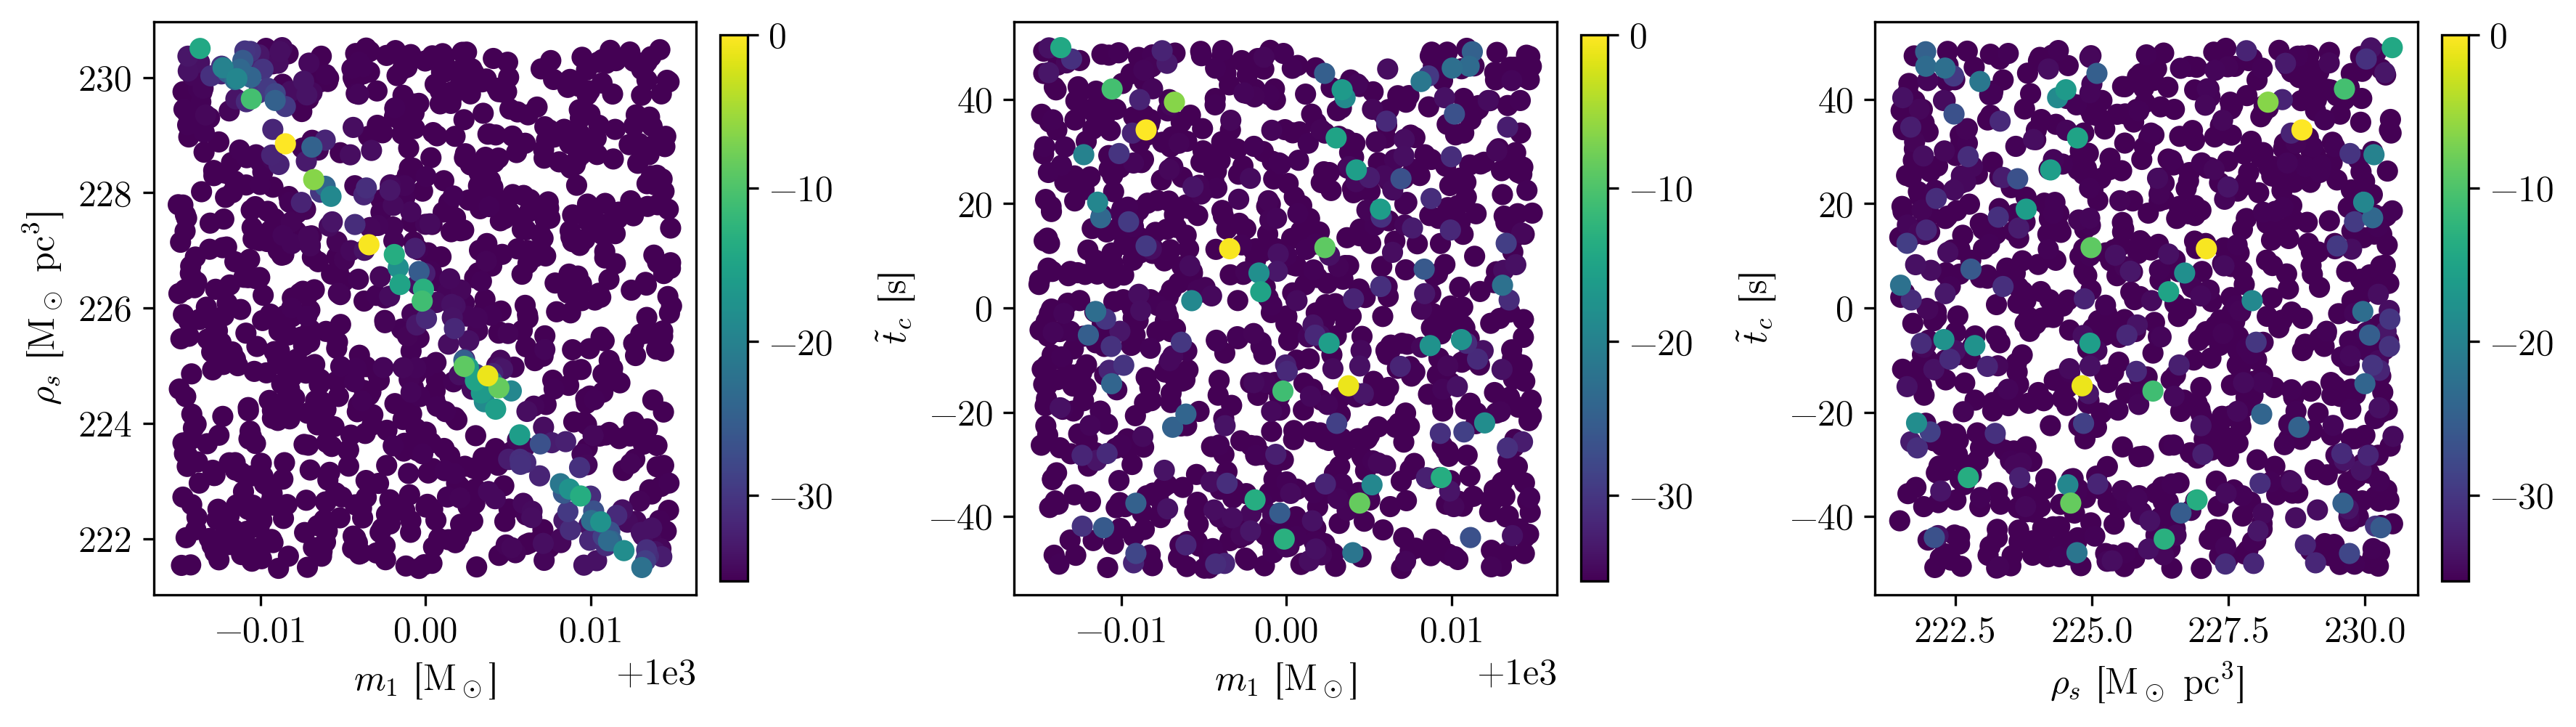

In [191]:
combos = [(i, j) for i in range(len(labels) - 1) for j in range(i + 1, len(labels))]
order = np.argsort(logLs)

fig, axes = plt.subplots(1, len(combos), figsize=(4 * len(combos), 3.5))
if not hasattr(axes, "__len__"):
    axes = [axes]

for (i, j), ax in zip(combos, axes):
    ax.set_xlabel(labels[i])
    ax.set_ylabel(labels[j])
    sc = ax.scatter(xs[order, i], xs[order, j], c=(logLs - logLs.max())[order])
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()

In [151]:
rho_ss = jnp.linspace((1 - 1e-2) * rho_s_ref, (1 + 1e-2) * rho_s_ref, 200)
logLs = [
    loglikelihood(
        make_dynamic_dress(m_1_ref * (1 - 0), m_2_ref, rho_s, gamma_s_ref, dL=dL_ref),
        dd_s, f_l, dd_s.f_c, 5000, 3000
    ) for rho_s in rho_ss]

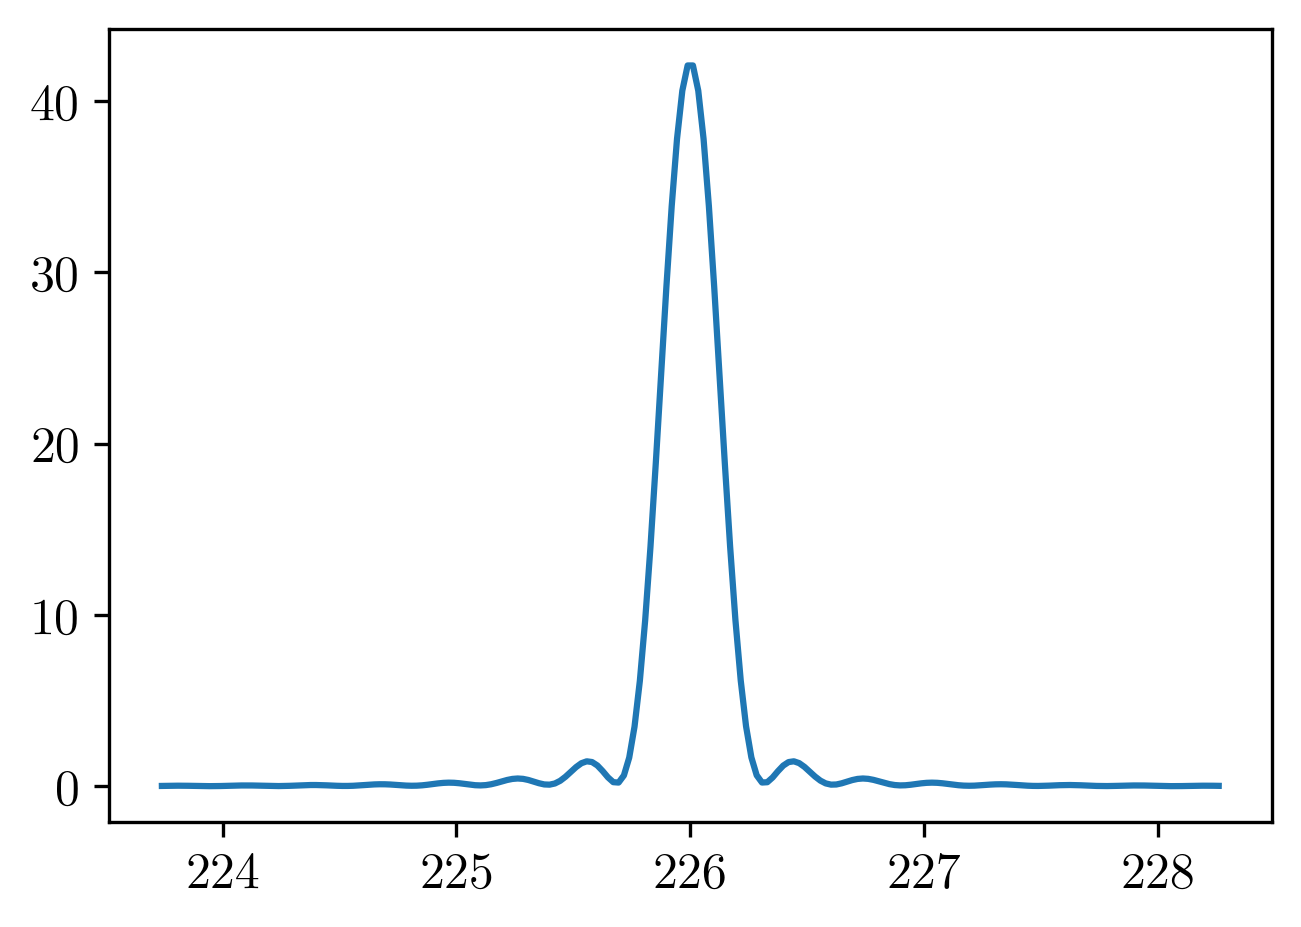

In [152]:
plt.plot(rho_ss / (MSUN / PC**3), logLs)

Run sampler

`2756it [02:01, 22.77it/s, bound: 0 | nc: 6 | ncall: 16613 | eff(%): 16.589 | loglstar:   -inf <  0.289 <    inf | logz:  0.031 +/-  0.012 | dlogz:  2.328 >  1.009]`

In [17]:
sampler = dynesty.NestedSampler(
    logL_4d, ptform, len(labels), nlive=50 * (4 + 1) * 3, bound="multi"
)
sampler.run_nested()
results = sampler.results

1016it [00:15, 65.69it/s, bound: 0 | nc: 4 | ncall: 2864 | eff(%): 35.475 | loglstar:   -inf <  0.155 <    inf | logz: -0.236 +/-  0.028 | dlogz:  1.817 >  0.759] 


KeyboardInterrupt: 

#### Hypergeometric dress
Not working

In [2]:
import dynesty
from dynesty import plotting as dyplot

In [4]:
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
hd_s = make_hypgeom_dress(m_1, m_2, rho_s, gamma_s)


@jax.jit
def logL_3d(x):
    lam, M_chirp_MSUN, tT_c = x
    dd_h = HypGeomDress(
        lam,  # ~ gamma_s
        hd_s.eta,  # ~ c_f
        M_chirp_MSUN * MSUN,
        hd_s.f_b,  # ~ q
        hd_s.Phi_c,  # fixed
        tT_c,
        hd_s.dL_iota,  # value doesn't matter
        get_f_isco(get_m_1(M_chirp_MSUN * MSUN, hd_s.q))
    )
    f_h = jnp.maximum(hd_s.f_c, dd_h.f_c)
    return loglikelihood(dd_h, hd_s, f_l, f_h, 3000, 3000)

In [3]:
print(logL_3d(jnp.array([hd_s.lam, hd_s.M_chirp / MSUN, hd_s.tT_c])))
print(logL_3d(jnp.array([hd_s.lam, hd_s.M_chirp / MSUN, hd_s.tT_c])))

NameError: name 'dd_s' is not defined

In [15]:
r_gamma_s = 1e-1
r_c_f = 2e-1
r_M_chirp_MSUN = 1e-4
d_tT_c = 120

labels = (
    r"$\gamma_s$",
    r"$c_f$ [?]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\tilde{t}_c$ [s]"
)

def ptform(u):
    return jnp.array([
        dd_s.gamma_s * (1 + r_gamma_s * (2 * u[0] - 1)),
        dd_s.c_f * (1 + r_c_f * (2 * u[1] - 1)),
        dd_s.M_chirp / MSUN * (1 + r_M_chirp_MSUN * (2 * u[2] - 1)),
        d_tT_c * (2 * u[3] - 1)
    ])

Run sampler

`2756it [02:01, 22.77it/s, bound: 0 | nc: 6 | ncall: 16613 | eff(%): 16.589 | loglstar:   -inf <  0.289 <    inf | logz:  0.031 +/-  0.012 | dlogz:  2.328 >  1.009]`

In [17]:
sampler = dynesty.NestedSampler(
    logL_4d, ptform, len(labels), nlive=50 * (4 + 1) * 3, bound="multi"
)
sampler.run_nested()
results = sampler.results

1016it [00:15, 65.69it/s, bound: 0 | nc: 4 | ncall: 2864 | eff(%): 35.475 | loglstar:   -inf <  0.155 <    inf | logz: -0.236 +/-  0.028 | dlogz:  1.817 >  0.759] 


KeyboardInterrupt: 